Возьмём открытый транспортный датасет — Bike Sharing Dataset (предсказание количества аренд велосипедов).

Что делает код: скачивает датасет, обучает 5 выбранных моделей и сравнивает их по RMSE, MAE и R².

Размер данных: (731, 11)

📊 Сравнение моделей:
              model   test_RMSE    test_MAE   test_R2     cv_RMSE
0  GradientBoosting  662.321482  462.770118  0.890603  651.166100
1        ExtraTrees  677.313632  437.562857  0.885594  669.167625
2      RandomForest  677.365029  429.792177  0.885577  680.843575
3        KNeighbors  824.128098  571.823129  0.830622  796.571192
4          AdaBoost  884.045598  670.149479  0.805097  840.452998


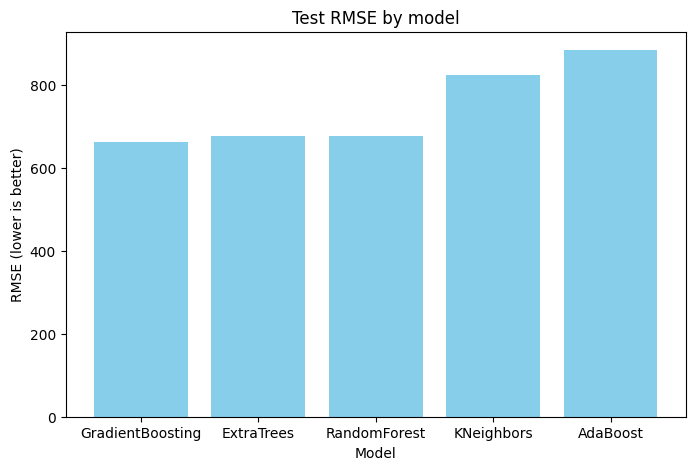

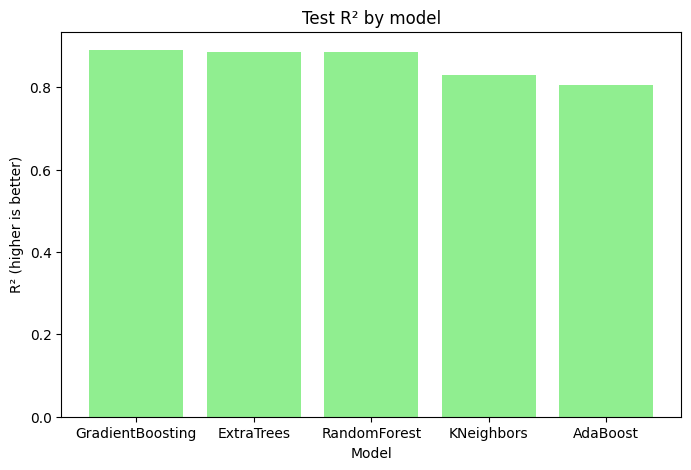


🏆 Лучшая модель: GradientBoosting (RMSE=662.3215, R²=0.8906)

Файл с результатами сохранён: regressors_comparison_bike.csv


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import requests
import zipfile
import io

# ===============================
# 1. Загружаем транспортный датасет (Bike Sharing Dataset, UCI)
# ===============================
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"

# Download the zip file
response = requests.get(url)

# Extract the desired csv file from the zip
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    with z.open('day.csv') as f:
        df = pd.read_csv(f, header=0, sep=',', quotechar='"',
                         usecols=lambda c: c not in ["instant","dteday","casual","registered"])


# Целевая переменная (количество аренд велосипедов)
y = df["cnt"]
X = df.drop(columns=["cnt"])

print("Размер данных:", X.shape)

# ===============================
# 2. Делим данные на train/test
# ===============================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ===============================
# 3. Определяем модели
# ===============================
models = {
    "GradientBoosting": GradientBoostingRegressor(random_state=42, n_estimators=100),
    "RandomForest": RandomForestRegressor(random_state=42, n_estimators=100, n_jobs=-1),
    "ExtraTrees": ExtraTreesRegressor(random_state=42, n_estimators=100, n_jobs=-1),
    "AdaBoost": AdaBoostRegressor(random_state=42, n_estimators=100),
    "KNeighbors": KNeighborsRegressor(n_jobs=-1)
}

# ===============================
# 4. Обучаем и считаем метрики
# ===============================
results = []
cv = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    pipe = make_pipeline(StandardScaler(), model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # Calculate RMSE manually
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # кросс-валидация (RMSE)
    cv_mse = -np.mean(cross_val_score(pipe, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    cv_rmse = np.sqrt(cv_mse)

    results.append({
        "model": name,
        "test_RMSE": rmse,
        "test_MAE": mae,
        "test_R2": r2,
        "cv_RMSE": cv_rmse
    })

results_df = pd.DataFrame(results).sort_values("test_RMSE").reset_index(drop=True)

# ===============================
# 5. Выводим результаты
# ===============================
print("\n📊 Сравнение моделей:")
print(results_df)

# Визуализация RMSE
plt.figure(figsize=(8,5))
plt.bar(results_df['model'], results_df['test_RMSE'], color="skyblue")
plt.title("Test RMSE by model")
plt.ylabel("RMSE (lower is better)")
plt.xlabel("Model")
plt.show()

# Визуализация R²
plt.figure(figsize=(8,5))
plt.bar(results_df['model'], results_df['test_R2'], color="lightgreen")
plt.title("Test R² by model")
plt.ylabel("R² (higher is better)")
plt.xlabel("Model")
plt.show()

# ===============================
# 6. Лучший регрессор
# ===============================
best = results_df.iloc[0]
print(f"\n🏆 Лучшая модель: {best['model']} (RMSE={best['test_RMSE']:.4f}, R²={best['test_R2']:.4f})")

# Сохраним в CSV
results_df.to_csv("regressors_comparison_bike.csv", index=False)
print("\nФайл с результатами сохранён: regressors_comparison_bike.csv")